# Optimized Resolvent Splitting Examples

This notebook generates the figures in our paper, which outlines the use of a semi-definite programming framework for optimizing splitting algorithms which solve the following monotone inclusion problem:

\begin{equation}
0 \in \sum_{i=1}^{n} A_{i}(x).
\end{equation}

It does so by finding valid matrices $L$ and $W$ for the following set of iterations, where bolded entries are lifted, i.e. $\mathrm{x} = (x_1, \dots, x_n)$:

\begin{align}
\mathrm{x} &= J_{\mathrm{A}}\left(\mathrm{v}^{k} + \mathrm{L} \mathrm{x}\right)\\
\mathrm{v}^{k+1} &= \mathrm{v}^{k} - \gamma \mathrm{W} \mathrm{x}.
\end{align}

$L$ is lower diagonal, so we work with a symmetrized matrix $Z = 2I - L - L^T$

In [1]:
import numpy as np
import oars
from oars.matrices import *
from oars.utils import *
from oars.pep import *
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib
# matplotlib.use('nbagg')
import seaborn as sns
sns.set()
from matplotlib.colors import CenteredNorm
import cvxpy as cvx
from collections import defaultdict



Our first example builds the matrices, which can be thought of as the graph Laplacians of communication graphs for the nodes in a distributed setting, to avoid specific communication paths. 

We suppose a set of two clusters (0-2) and (3-5) which can only communicate within clusters and via a link between 0-3.

We then plot a Gantt chart for the distributed execution of the resulting algorithm.

We take as our objective function here the spectral norm of $Z-W$, which promotes graph similarity.

In [2]:
# Data for matrices in cluster example (6x6)
n = 6
Z_fixed = {(r,c):0 for r in range(4,6) for c in range(3)}
Z_fixed[(3,1)] = 0
Z_fixed[(3,2)] = 0

Z, W = getMinSpectralDifference(n, fixed_Z=Z_fixed, fixed_W=Z_fixed)


In [3]:
# Figure 3
t = 0.016*np.ones(n)
l = 0.00025*np.ones((n, n))
l[0, 3] = 0.01
l[3, 0] = 0.01  
fig = getGantt(t, l, Z, W, title="Cluster Algorithm Parallelism", itrs=5)
fig.show()
#if you want to save the figure as a separate file
saving = False # set to True to save the figures
if saving:
    import os
    if ~os.path.exists('figs'): os.makedirs('figs')
    fig.write_image("figs/fig_gantt.pdf")

In this example, we visually depict the different matrices generates by changing the objective function between maximizing algebraic connectivity, minimizing SLEM, minimizing total effective resistance, and minimizing the spectral norm of the difference of the matrices.

We also demonstrate the use of the getBlockMin function to build the constraint set for the SDP to guarantee that the nodes can execute in blocks. If the compute and communication times are constant and uniform, this guarantees that the algorithm can execute with the highest possible degree of parallelism possible for this type of splitting.

In [4]:
# Figure 4 helper
def cplot(W,Z):
    vmin = np.floor(np.min(np.minimum(W, Z)))
    cm = plt.cm.coolwarm
    fig, ax = plt.subplots(1, 2, figsize=(12, 6))
    x = -np.arange(n)
    y = np.arange(n)
    ax[0].pcolormesh(x, y, W, norm=CenteredNorm(), cmap=cm) #, vmin=vmin, vmax=2)
    ax[0].set_title(r"$W$")
    ax[0].axis('off')
    ax[0].set_aspect('equal')

    pc = ax[1].pcolormesh(x, y, Z, norm=CenteredNorm(), cmap=cm)
    ax[1].set_title(r"$Z$")
    ax[1].axis('off')
    ax[1].set_aspect('equal')

    # Add colorbar
    plt.tight_layout()
    
    fig.colorbar(pc, ax=ax.ravel().tolist())
    return fig

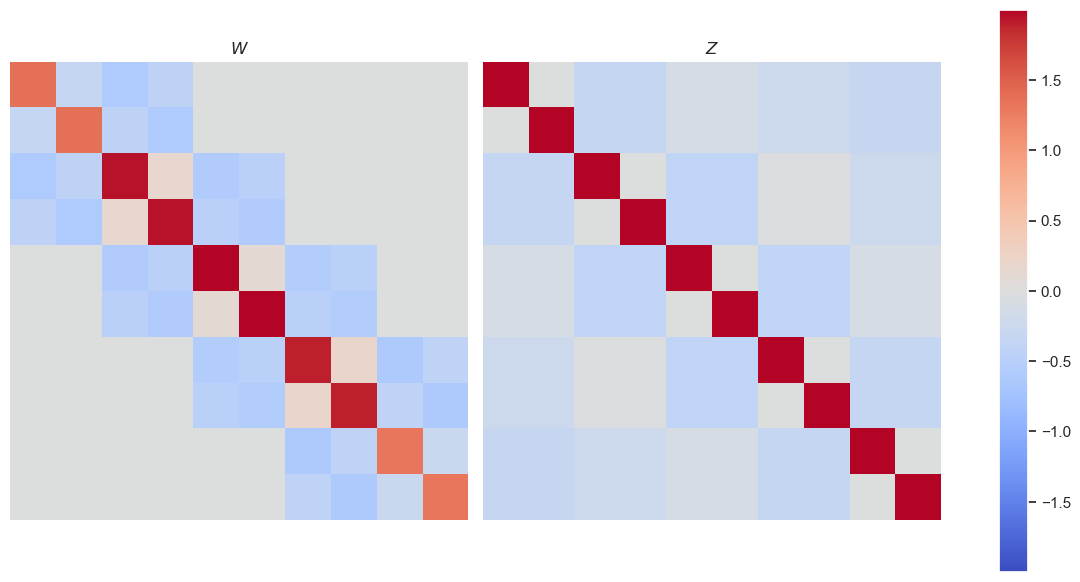

In [5]:
# Figure 4
n = 10
m = 2
Z, W = getBlockMin(n, m, builder=getMaxConnectivity)

fig = cplot(W, Z)

# Save as pdf
if saving: fig.savefig("figs/fig_block_fiedler.pdf")


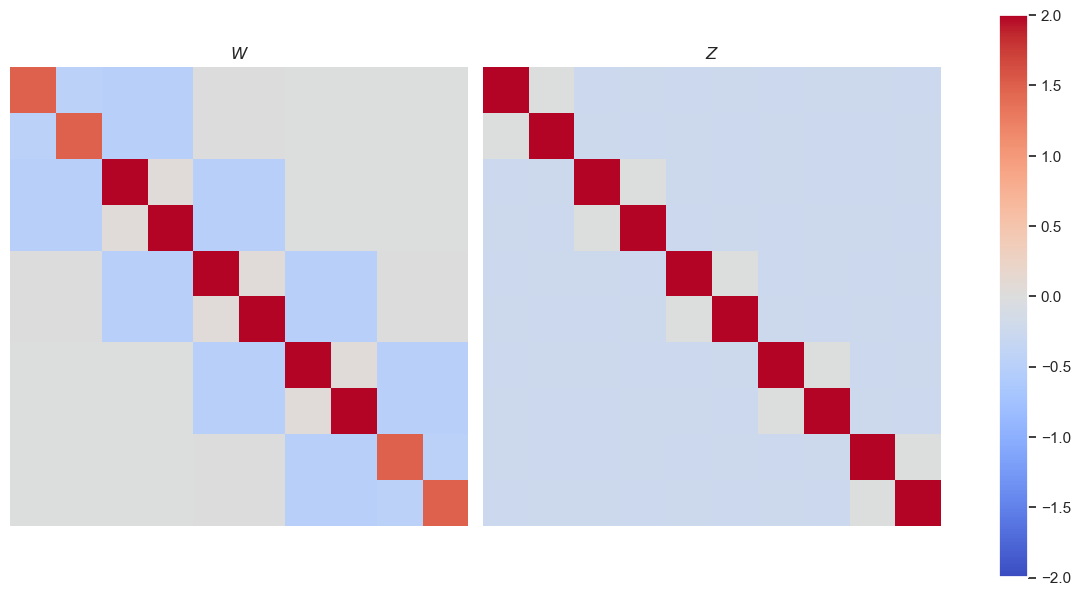

In [6]:
# Figure 4
Z, W = getBlockMin(n, m, builder=getMinSLEM)

fig = cplot(W, Z)
if saving: fig.savefig("figs/fig_block_slem.pdf")


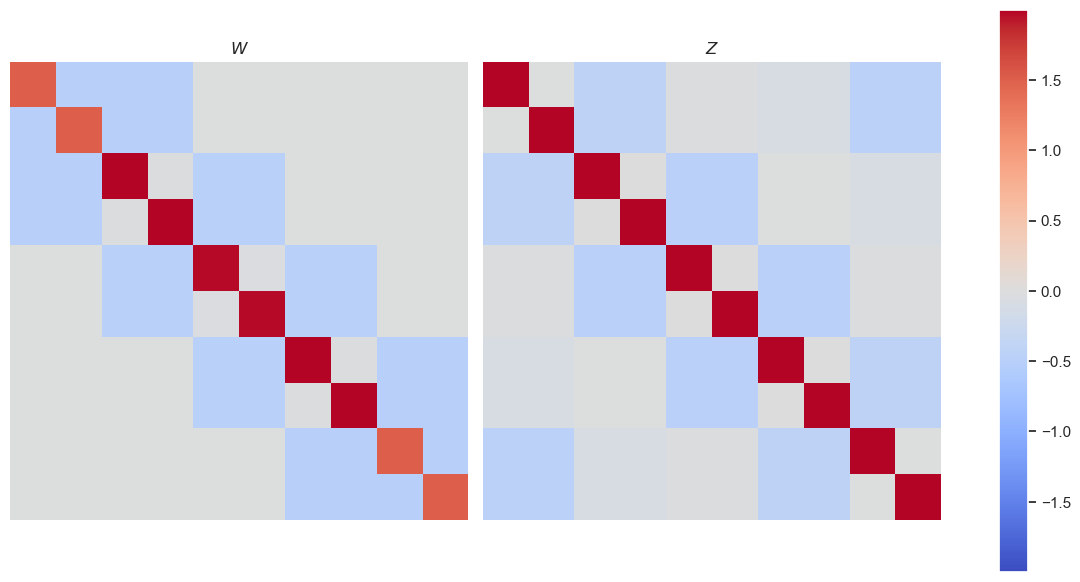

In [7]:
# Figure 4
Z, W = getBlockMin(n, m, builder=getMinResist)

fig = cplot(W, Z)
if saving: fig.savefig("figs/fig_block_resist.pdf")


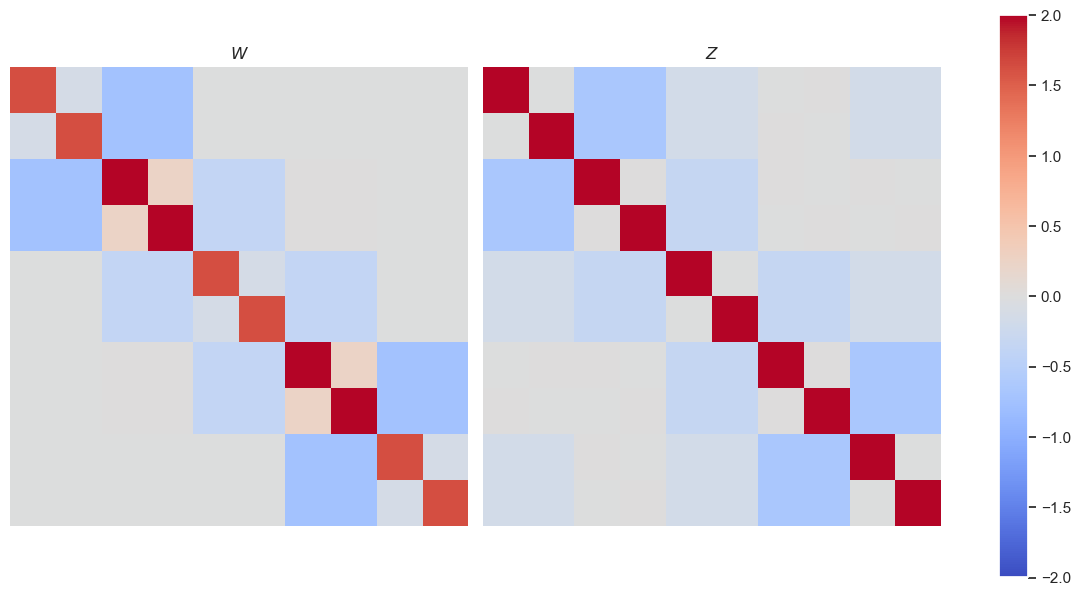

In [8]:
# Figure 4
Z, W = getBlockMin(n, m, builder=getMinSpectralDifference)

fig = cplot(W, Z)
if saving: fig.savefig("figs/fig_block_lw.pdf")


This example shows a comparison of the execution of the block designs when the computation times are not uniform, and the use of the getMinIteration function to generate designs which minimize the iteration time.

In [9]:
# Figure 5 (hangs if executed in Windows using Kaleido 0.1.0post1)
# try pip install kaleido==0.1.0post1
n = 6
t = np.ones(n)
l = np.ones((n,n))/10
t[0] = 6
t[2] = 6
t[3] = 6

for i in range(1, n//2+1):
    Zb, Wb = getBlockMin(n, i, builder=getMinResist)
    if i == 1:
        itrs = 6
    else:
        itrs = 7
    fig = getGantt(t, l, Zb, Wb, title=str(n//i)+"-Block", itrs=itrs)
    
    if saving: fig.write_image("figs/fig_misdp"+str(n//i)+"block.pdf")
    fig.show()

Z, W = getMinIteration(n, t=t, l=l, builder=getMinResist)

fig = getGantt(t, l, Z, W, title="Minimum Iteration", itrs=12)

if saving: fig.write_image("figs/fig_misdp_min_cycle.pdf")
fig.show()

In several of the following examples, we use the PEP formulation to find the contraction factor for the algorithm designs in two scenarios:

1) $(n)$ 2-Lipschitz 1-strongly monotone operators

2) $(n-1)$ 2-Lipschitz 1-strongly monotone operators, and 1 unrestricted maximal monotone operator (this simulates having the subdifferential of an indicator function over some convex set)

In the figure 6 example, we use a fixed step size of 0.5.

We then compare the different algorithm designs, including the spectral objectives using our SDP, and some existing designs in the literature.

In [10]:
from warnings import warn
if 'MOSEK' not in cvx.installed_solvers():
    warn('''These experiments were conducted with Mosek as the underlying conic solver for CVXPY.  Mosek was not detected on your system. Running without Mosek will generate different results than those in the paper, including lack of convergence on larger problems.''')

In [11]:
# Figure 6 - contraction rate results
# Function to generate list of all test matrices
def getTestMatrices(n):
    cases = []
    Ws = []
    names = ['Full', 'MT']
    Lf, Wf = getFull(n)
    Mf = getMfromWCholesky(Wf)
    cases.append((Lf, Mf))
    Ws.append(Wf)
    Lmt, Wmt = getMT(n)
    Mmt = getMfromWCholesky(Wmt)
    cases.append((Lmt, Mmt))
    Ws.append(Wmt)
    i = n//2
    for obj in [getMinSLEM, getMinResist, getMaxConnectivity]:
        L, W = getBlockMin(n, i, builder=obj)
        M = getMfromWCholesky(W)
        cases.append((L, M))
        Ws.append(W)
        title = f"2-Block "+ obj.__name__
        names.append(title)
        
    return cases, names, Ws
    
def getMatrixContraction(cases, names, Lc=2, mu=1, gamma=0.5):
    '''Get contraction factors for matrix cases

    Args:
        cases (list): list of cases with L and M
        names (list): list of names
        Lc (float): Lipschitz constant
        mu (float): strong convexity parameter
        gamma (float): step size

    Returns:
        taus (dict): dictionary of contraction factors
    '''

    taus = {}
    for i, (L, M) in enumerate(cases):
        n = L.shape[0]
        
        ls = np.ones(n)*Lc
        mus = np.ones(n)*mu
        
        tau = getReducedContractionFactor(L, M, ls, mus)
        taus[names[i]] = tau
        print(names[i], tau)
    return taus



In [12]:
# Figure 6 helper
def testFixedRate(start=4, end=31, lc=2, mc=1):
    tau_results = defaultdict(list) 
    for n in range(start, end, 2):
        print(f"Testing optimal rate on {n} nodes")
        ls = np.ones(n) * lc
        mus = np.ones(n) * mc
        cases, names, Ws = getTestMatrices(n)
        for i, (L, M) in enumerate(cases):
            tau = getReducedContractionFactor(L, M, ls, mus)
            tau_results[names[i]].append(tau)


    # Convert results to df
    tau_df = pd.DataFrame(tau_results)
    tau_df.index = range(start, end, 2)

    return tau_df

In [13]:
# Figure 6a
tau_df = testFixedRate(start=6, end=31)


Testing optimal rate on 6 nodes
Testing optimal rate on 8 nodes
Testing optimal rate on 10 nodes
Testing optimal rate on 12 nodes
Testing optimal rate on 14 nodes
Testing optimal rate on 16 nodes
Testing optimal rate on 18 nodes
Testing optimal rate on 20 nodes
Testing optimal rate on 22 nodes
Testing optimal rate on 24 nodes
Testing optimal rate on 26 nodes
Testing optimal rate on 28 nodes
Testing optimal rate on 30 nodes


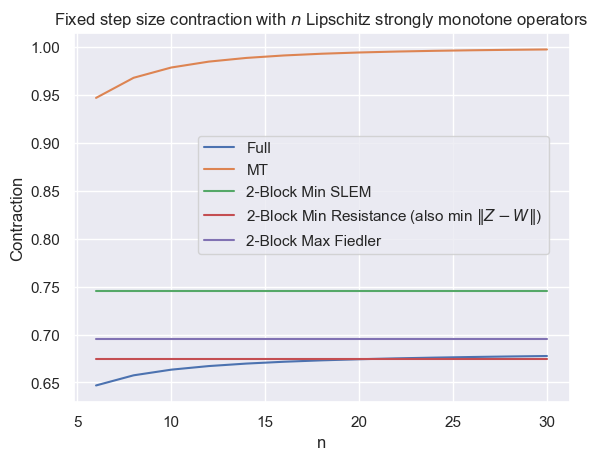

In [14]:
# Plot figure 6a
fig, ax = plt.subplots()
tau_df.plot(ax=ax)

ax.set_xlabel("n")
ax.set_ylabel("Contraction")
ax.set_title(r"Fixed step size contraction with $n$ Lipschitz strongly monotone operators")
ax.legend(['Full', 'MT', '2-Block Min SLEM', r'2-Block Min Resistance (also min $\|Z-W\|$)', '2-Block Max Fiedler'], loc=(0.25,0.4))
if saving: fig.savefig("figs/fig6a.pdf", format="pdf", bbox_inches="tight")

In [15]:
# Figure 6b helper
def testFixedRateProj(start=4, end=31, lc=2, mc=1):
    tau_results = defaultdict(list) 
    for n in range(start, end, 2):
        print(f"Testing optimal rate on {n} nodes")
        ls = np.ones(n) * lc
        ls[n-1] = np.inf
        mus = np.ones(n) * mc
        mus[n-1] = 0
        cases, names, Ws = getTestMatrices(n)
        for i, (Z, M) in enumerate(cases):
            tau = getReducedContractionFactor(Z, M, ls, mus)
            tau_results[names[i]].append(tau)


    # Convert results to df
    tau_df = pd.DataFrame(tau_results)
    tau_df.index = range(start, end, 2)

    return tau_df

In [16]:
# Figure 6b
tau_df = testFixedRateProj(start=6, end=31)


Testing optimal rate on 6 nodes
Testing optimal rate on 8 nodes
Testing optimal rate on 10 nodes
Testing optimal rate on 12 nodes
Testing optimal rate on 14 nodes
Testing optimal rate on 16 nodes
Testing optimal rate on 18 nodes
Testing optimal rate on 20 nodes
Testing optimal rate on 22 nodes
Testing optimal rate on 24 nodes
Testing optimal rate on 26 nodes
Testing optimal rate on 28 nodes
Testing optimal rate on 30 nodes


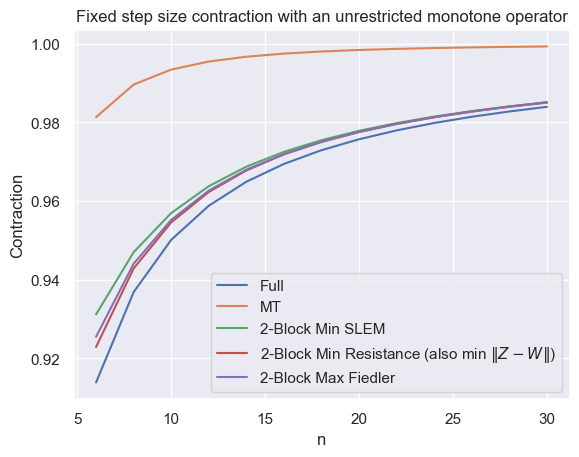

In [17]:
# Plot figure 6b
fig, ax = plt.subplots()
tau_df.plot(ax=ax)

ax.set_xlabel("n")
ax.set_ylabel("Contraction")
ax.set_title("Fixed step size contraction with an unrestricted monotone operator")
ax.legend(['Full', 'MT', '2-Block Min SLEM', r'2-Block Min Resistance (also min $\|Z-W\|$)', '2-Block Max Fiedler'], loc="lower right")
if saving: fig.savefig("figs/fig6b.pdf", format="pdf", bbox_inches="tight")

In figure 7 we repeat the analysis, but using an optimal step size we derive from an extension of the dual of the PEP. This also demonstrates the use of the `getReducedContractionOptGamma` function, which generates a step size which minimizes the contraction factor for the reduced version of the algorithm:

\begin{align}
\mathrm{x} &= J_{\mathrm{A}}\left(-\mathrm{M}^{T} \mathrm{z}^{k} + \mathrm{L} \mathrm{x}\right)\\
\mathrm{z}^{k+1} &= \mathrm{z}^{k} + \gamma \mathrm{M} \mathrm{x}. 
\end{align}

where $M^T M = W$

In [18]:
# Figure 7 helper
def testOptimalRate(start=4, end=31, lc=2, mc=1):
    tau_results = defaultdict(list) 
    for n in range(start, end, 2):
        print(f"Testing optimal rate on {n} nodes")
        ls = np.ones(n) * lc
        ms = np.ones(n) * mc
        cases, names, Ws = getTestMatrices(n)
        for i, (Z, M) in enumerate(cases):
            tau, gamma = getReducedContractionOptGamma(Z, M, ls, ms)
            tau_results[names[i]].append(tau)


    # Convert results to df
    tau_df = pd.DataFrame(tau_results)
    tau_df.index = range(start, end, 2)

    return tau_df

In [19]:
# Figure 7 helper
def plotTau(tau_df, title):
    fig, ax = plt.subplots()
    tau_df.plot(ax=ax)
    ax.set_xlabel("n")
    ax.set_ylabel("Contraction") #$\\tau$
    ax.set_title(title)
    ax.legend(['Full', 'MT', '2-Block Min SLEM', r'2-Block Min Resistance (also min $\|Z-W\|$)', '2-Block Max Fiedler'], loc="center right")
    #ax.legend(loc='center right')
    #plt.show()
    return fig

In [20]:
# Figure 7
tau_df = testOptimalRate(start=4, end=31)

if saving: tau_df.to_csv("figs/fig_opt_gamma_strong.csv", index=False)


Testing optimal rate on 4 nodes
Testing optimal rate on 6 nodes
Testing optimal rate on 8 nodes
Testing optimal rate on 10 nodes
Testing optimal rate on 12 nodes
Testing optimal rate on 14 nodes
Testing optimal rate on 16 nodes
Testing optimal rate on 18 nodes
Testing optimal rate on 20 nodes
Testing optimal rate on 22 nodes
Testing optimal rate on 24 nodes
Testing optimal rate on 26 nodes
Testing optimal rate on 28 nodes
Testing optimal rate on 30 nodes


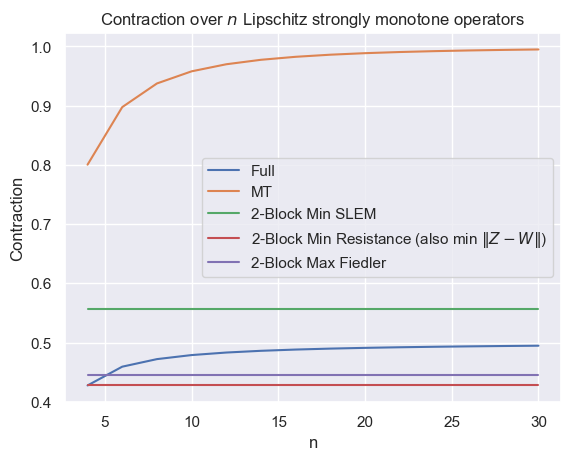

In [21]:
# Figure 7
fig = plotTau(tau_df, "Contraction over $n$ Lipschitz strongly monotone operators")
if saving: fig.savefig("figs/fig_opt_gamma_strong.pdf", format="pdf", bbox_inches="tight")

In [22]:
# Figure 7 helper
def testOptimalRateProj(start=4, end=31, lc=2, mc=1):
    tau_results = defaultdict(list) 
    for n in range(start, end, 2):
        print(f"Testing optimal rate on {n} nodes")
        ls = np.ones(n) * lc
        ls[n-1] = np.inf
        mus = np.ones(n) * mc
        mus[n-1] = 0
        cases, names, Ws = getTestMatrices(n)
        for i, (Z, M) in enumerate(cases):
            tau, _ = getReducedContractionOptGamma(Z, M, ls, mus)
            tau_results[names[i]].append(tau)


    # Convert results to df
    tau_df = pd.DataFrame(tau_results)
    tau_df.index = range(start, end, 2)

    return tau_df

In [23]:
# Figure 7b
tau_df = testOptimalRateProj(start=4, end=31)

if saving: tau_df.to_csv("figs/fig_opt_gamma_proj.csv", index=False)


Testing optimal rate on 4 nodes
Testing optimal rate on 6 nodes
Testing optimal rate on 8 nodes
Testing optimal rate on 10 nodes
Testing optimal rate on 12 nodes
Testing optimal rate on 14 nodes
Testing optimal rate on 16 nodes
Testing optimal rate on 18 nodes
Testing optimal rate on 20 nodes
Testing optimal rate on 22 nodes
Testing optimal rate on 24 nodes
Testing optimal rate on 26 nodes
Testing optimal rate on 28 nodes
Testing optimal rate on 30 nodes


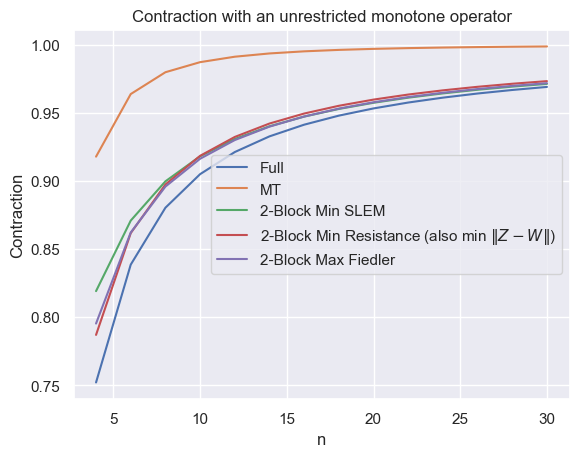

In [24]:
# Figure 7b
fig = plotTau(tau_df, "Contraction with an unrestricted monotone operator")

if saving: fig.savefig("figs/fig7b.pdf", format="pdf", bbox_inches="tight")

In figure 8 we examine the impact of operator ordering on the contraction factor. In this example (and previous ones), we illustrate the use of some of the prebuilt matrix functions.

`getMT(n)` returns the Malitsky-Tam algorithm design over $n$ operators

`getRyu(n)` returns the Tam extension of the Ryu algorithm design over $n$ operators

`getFull(n)` returns the fully connected algorithm with equal weights over $n$ operators

We also use a helper function `getMfromWCholesky` to return a valid $M \in \mathbf{R}^{n-1 \times n}$ such that $M^T M = W$

In [25]:
# Figure 8 - operator ordering
Lc=2
mu=1


taus = defaultdict(list)
for n in range(4, 31, 2):
    print(f"Testing optimal rate on {n} nodes")
    Lb, Wb = getBlockMin(n, n//2)
    Mb = getMfromWCholesky(Wb)
    Lmt, Wmt = getMT(n)
    Mmt = getMfromWCholesky(Wmt)
    Lr, Wr = getRyu(n)
    Mr = getMfromWCholesky(Wr)
    Lmax, Wmax = getFull(n)
    Mmax = getMfromWCholesky(Wmax)

    cases = [(Lb, Mb), (Lmt, Mmt), (Lr, Mr), (Lmax, Mmax)]
    names = ["2-Block", "MT", "Ryu", "Full"]
    ls = np.ones(n)*Lc
    ls[n-1] = np.inf
    mus = np.ones(n)*mu
    mus[n-1] = 0
    for i, (Z, M) in enumerate(cases):
        tau, _ = getReducedContractionOptGamma(Z, M, ls, mus)
        taus[names[i]].append(tau)

    ls = np.ones(n)*Lc
    ls[0] = np.inf
    mus = np.ones(n)*mu
    mus[0] = 0
    for i, (Z, M) in enumerate(cases):
        tau, _ = getReducedContractionOptGamma(Z, M, ls, mus)        
        taus[names[i]+" reverse"].append(tau)

Testing optimal rate on 4 nodes
Testing optimal rate on 6 nodes
Testing optimal rate on 8 nodes
Testing optimal rate on 10 nodes
Testing optimal rate on 12 nodes
Testing optimal rate on 14 nodes
Testing optimal rate on 16 nodes
Testing optimal rate on 18 nodes
Testing optimal rate on 20 nodes
Testing optimal rate on 22 nodes
Testing optimal rate on 24 nodes
Testing optimal rate on 26 nodes
Testing optimal rate on 28 nodes
Testing optimal rate on 30 nodes


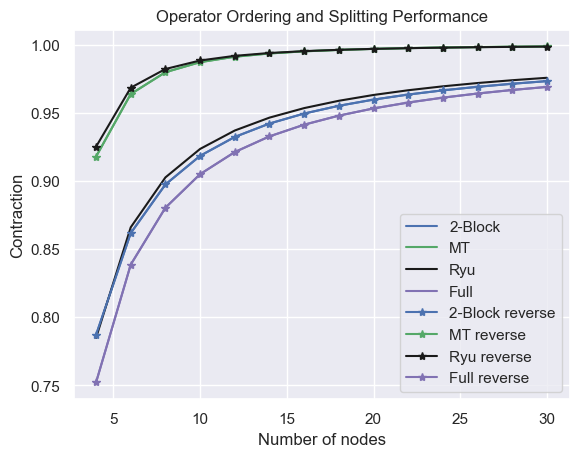

In [26]:
# Figure 8 - operator ordering
df = pd.DataFrame(taus)
df.index = range(4, 31, 2)

# Plot the results
colors = ['blue', 'green', 'red', 'purple']
styles = ['b-', 'g-', 'k-', 'm-', 'y--', 'c--', 'r--', 'p--']
styles = ['b-', 'g-', 'k-', 'm-', 'b*-', 'g*-', 'k*-', 'm*-']

if saving: df.to_csv("figs/fig_function_ordering_opt.csv", index=False)
df.plot(style=styles)
plt.xlabel("Number of nodes")
plt.ylabel("Contraction")
plt.title("Operator Ordering and Splitting Performance")

if saving: plt.savefig("figs/fig_function_order_opt.pdf", format="pdf", bbox_inches="tight")
plt.show()

Figure 9 examines the impact of block count in the $d$-Block designs on the reduced contraction factor.

In [27]:
# Figure 9 - block size

# Function to generate list of all test matrices
def getTestMatricesBlocks(n):
    cases = []
    names = ['Full', 'MT']
    objs = ['Full', 'MT']
    blocksizes = ['', '']
    blocklist = ['', '']
    Lf, Wf = getFull(n)
    Mf = getMfromWCholesky(Wf)
    cases.append((Lf, Mf))
    Lmt, Wmt = getMT(n)
    Mmt = getMfromWCholesky(Wmt)
    cases.append((Lmt, Mmt))
    objstring = ['MinSLEM', 'MinResist', 'getMaxConnectivity', 'Min |Z-W|']
    for i in range(2, n//2+1):
        if n % i != 0:
            continue
        for j, obj in enumerate([getMinSLEM, getMinResist, getMaxConnectivity, getMinSpectralDifference]):
            L, W = getBlockMin(n, i, builder=obj)
            M = getMfromWCholesky(W)
            cases.append((L, M))
            objs.append(objstring[j])
            blocksizes.append(i)
            blocklist.append(n//i)
            title = f"{n//i}-Block "+objstring[j]
            names.append(title)
        
    return cases, names, objs, blocksizes, blocklist

# Test function
def testMatrices(cases, names, lc=2, mu=1):
        
    taus = {}
    for i, (L, M) in enumerate(cases):
        ls = np.ones(len(L))*lc
        mus = np.ones(len(L))*mu
        
        tau, _ = getReducedContractionOptGamma(L, M, ls, mus)
        print(names[i], tau)
        taus[names[i]] = tau

    return taus

    

In [28]:
# Figure 9
results = []
for n in range(4, 25): #t < 120:
    print(n)
    cases, names, objs, blocksizes, blocks = getTestMatricesBlocks(n)
    taus = testMatrices(cases, names)
    # Each key in taus is a column, the row is the value of n
    for i in range(len(names)):
        k = names[i]
        v = taus[k]
        results.append({"n": n, "name": k, "obj": objs[i], "blocksize": blocksizes[i], "blocks":blocks[i], "tau": v})

df = pd.DataFrame(results)

if saving: df.to_csv("figs/taus_plus.csv", index=False)
df.set_index('n', inplace=True)


4
Full 0.42757264243870163
MT 0.8002281453197669
2-Block MinSLEM 0.5571563323030004
2-Block MinResist 0.4285714313486169
2-Block getMaxConnectivity 0.4444444922837189
2-Block Min |Z-W| 0.4285714295615013
5
Full 0.4476922209675467
MT 0.8613717840444194
6
Full 0.4592582042344319
MT 0.8973983347682897
3-Block MinSLEM 0.7129712945766307
3-Block MinResist 0.7182631444907567
3-Block getMaxConnectivity 0.7149701914264488
3-Block Min |Z-W| 0.7219681448031213
2-Block MinSLEM 0.5571562848664554
2-Block MinResist 0.4285714295483013
2-Block getMaxConnectivity 0.44444444676649425
2-Block Min |Z-W| 0.4285714391012484
7
Full 0.4667573414540386
MT 0.9210285463263077
8
Full 0.47200715470169285
MT 0.9373167138798192
4-Block MinSLEM 0.8312917026071186
4-Block MinResist 0.8108979753769874
4-Block getMaxConnectivity 0.8002312869710034
4-Block Min |Z-W| 0.941477505124461
2-Block MinSLEM 0.5571562864960922
2-Block MinResist 0.42857143703485306
2-Block getMaxConnectivity 0.44444444095154123
2-Block Min |Z-W| 

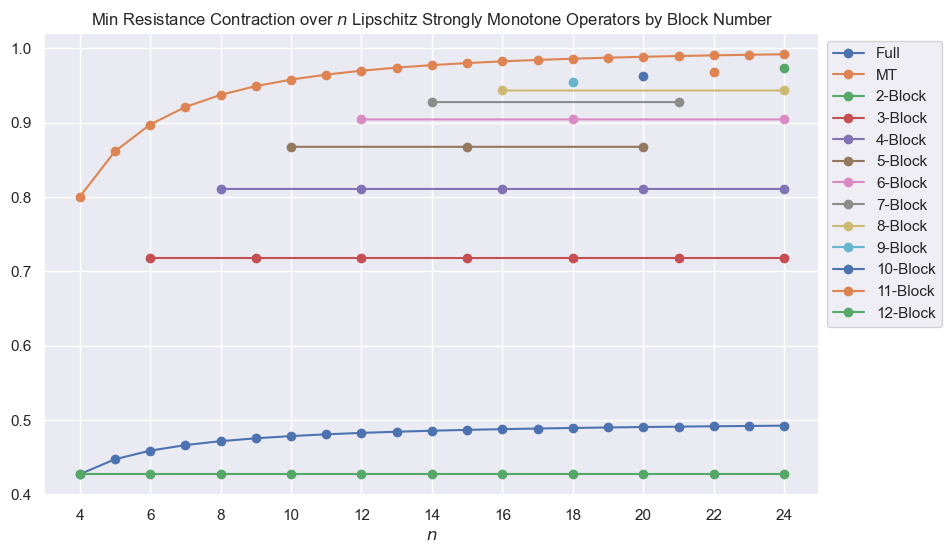

In [29]:
# Figure 9
df[df["obj"].isin(["MinResist", "Full", "MT"])].groupby(['obj', 'blocks'])['tau'].plot(marker='o', linestyle='-', figsize=(10, 6))
keys = ['Full', 'MT', '2-Block', '3-Block', '4-Block', '5-Block', '6-Block', '7-Block', '8-Block', '9-Block', '10-Block', '11-Block', '12-Block']
plt.legend(keys, bbox_to_anchor=(1, 1))

# Make x axis integer
plt.xticks(np.arange(4, 25, 2))
plt.xlabel(r"$n$")
plt.title("Min Resistance Contraction over $n$ Lipschitz Strongly Monotone Operators by Block Number")
if saving: plt.savefig("figs/fig_block_count.pdf", format="pdf", bbox_inches="tight")

In [30]:
# Figure 9 - Test function
def testMatricesProj(n, cases, names, lc=2, mu=1):
    ls = np.ones(n)*lc
    mus = np.ones(n)*mu
    ls[n-1] = np.inf
    mus[n-1] = 0
    taus = {}
    for i, (Z, M) in enumerate(cases):
        tau, _ = getReducedContractionOptGamma(Z, M, ls, mus)
        print(names[i], tau)
        taus[names[i]] = tau

    return taus

In [31]:
# Figure 9
projresults = []
for n in range(4,26): #t < 120:
    print(n)
    cases, names, objs, blocksizes, blocks = getTestMatricesBlocks(n)
    taus = testMatricesProj(n, cases, names)
    # Each key in taus is a column, the row is the value of n
    for i in range(len(names)):
        k = names[i]
        v = taus[k]
        
        projresults.append({"n": n, "name": k, "obj": objs[i], "blocksize": blocksizes[i], "blocks":blocks[i], "tau": v})

projdf = pd.DataFrame(projresults)
if saving: projdf.to_csv("figs/taus_proj.csv", index=False)
projdf.set_index('n', inplace=True)



4
Full 0.7521521274547781
MT 0.9177841369745806
2-Block MinSLEM 0.8191387835717695
2-Block MinResist 0.7870338919734876
2-Block getMaxConnectivity 0.7953598873831341
2-Block Min |Z-W| 0.7870338929140283
5
Full 0.804479212788819
MT 0.9475773165769151
6
Full 0.8385587406685645
MT 0.9636790407235943
3-Block MinSLEM 0.9037804471101512
3-Block MinResist 0.8989263836062485
3-Block getMaxConnectivity 0.9061871583499181
3-Block Min |Z-W| 0.9135498842509275
2-Block MinSLEM 0.8708680920504788
2-Block MinResist 0.8616700813961772
2-Block getMaxConnectivity 0.8621392257249626
2-Block Min |Z-W| 0.8616700814010753
7
Full 0.8625324131656764
MT 0.9733944272799407
8
Full 0.8803148080938081
MT 0.9796953548701692
4-Block MinSLEM 0.9474277363886522
4-Block MinResist 0.9366151343240023
4-Block getMaxConnectivity 0.9433024851609532
4-Block Min |Z-W| 0.973409934409352
2-Block MinSLEM 0.8996656566193365
2-Block MinResist 0.8973584357777739
2-Block getMaxConnectivity 0.8958143091479002
2-Block Min |Z-W| 0.8973

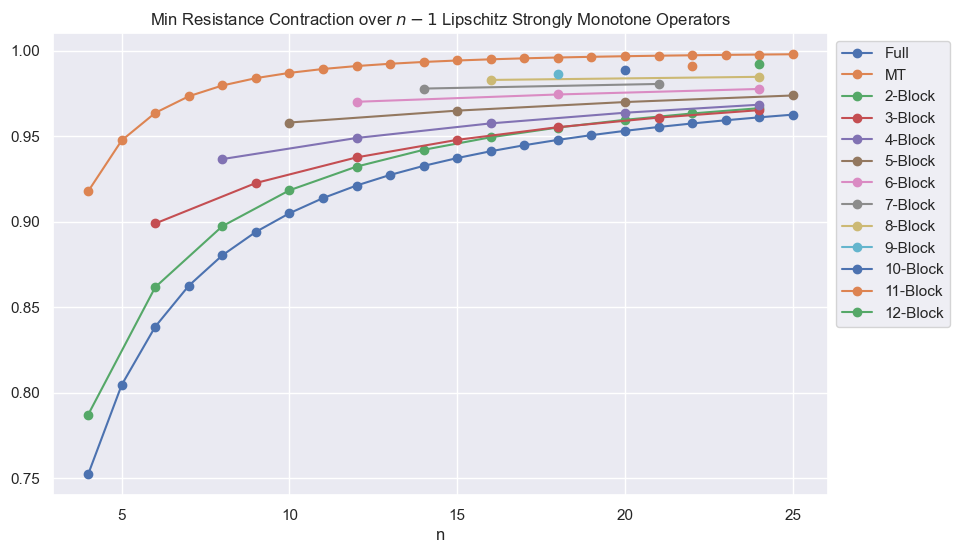

In [32]:
# Figure 9 Class 2 

projdf[projdf["obj"].isin(["MinResist", "Full", "MT"])].groupby(['obj', 'blocks'])['tau'].plot(marker='o', linestyle='-', figsize=(10, 6))

keys = ['Full', 'MT', '2-Block', '3-Block', '4-Block', '5-Block', '6-Block', '7-Block', '8-Block', '9-Block', '10-Block', '11-Block', '12-Block'] # If using df directly
plt.legend(keys, bbox_to_anchor=(1, 1))
plt.title("Min Resistance Contraction over $n-1$ Lipschitz Strongly Monotone Operators")
if saving: plt.savefig("figs/fig_block_count_proj.pdf", format="pdf", bbox_inches="tight")

Figure 10 combines the iteration time and contraction factor to depict how removing edges impacts algorithm design. We see that the 2-Block design strikes the optimal balance between connectivity (for faster contraction) and sparseness (for parallelism and faster iteration times)

This uses the `getIterationTime` function to return the iteration time.

In [33]:
# Figure 10 - pareto curves

from matplotlib.colors import CenteredNorm
def getTaus(Z, W, l=None, mu=None):

    M = getMfromWCholesky(W)
    h = getReducedContractionFactor(Z, M, l, mu, gamma=0.5)
    m, _ = getReducedContractionOptGamma(Z, M, l, mu)
    return h, m

def getContractTime(n, l, mu, builder=None, tol=0.5):
    Z_fixed = {}

    t = np.ones(n)
    ll = np.ones((n,n))
    results = {}
    for i in range(n//2):
        print(i)
        start = 0
        for k in range(2):
            for j in range(start, i + k*(n//2)):
                Z_fixed[(i + k*(n//2),j)] = 0
            Zs, Ws = builder(n, fixed_Z=Z_fixed)
            h, m = getTaus(Zs, Ws, l, mu)
            tt, _, _ = getIterationTime(t, ll, Zs, Ws, itrs=2)
            # r is number of entries in Z_fixed
            r = len(Z_fixed)
            tif = np.ceil(np.log(tol)/np.log(h)) # Total iterations fixed
            tio = np.ceil(np.log(tol)/np.log(m)) # Total iterations opt step
            ttf = tif*tt
            tto = tio*tt
            results[r] = {'Fixed':h , 'M Opt': m, 'Time': tt, 'Removed Edges': r, 'Fixed Total Iterations': tif, 'Opt Step Total Iterations': tio, 'Fixed Total Time': ttf, 'Opt Step Total Time': tto}
            print(results[r])
            start = n//2

    counter = 0
    for i in range(n//2 - 2):
        for j in range(i+1):
            r = n//2 + j
            c = n//2 - 1 - i + j
            Z_fixed[(r, c)] = 0
            counter += 1
            if counter % 10 == 0:
                Ls, Ws = builder(n, fixed_Z=Z_fixed)
                h, m = getTaus(Ls, Ws, l, mu)
                tt = 4
                # r is number of entries in Z_fixed
                rem = len(Z_fixed)    
                tif = np.ceil(np.log(tol)/np.log(h)) # Total iterations fixed
                tio = np.ceil(np.log(tol)/np.log(m)) # Total iterations opt step
                ttf = tif*tt
                tto = tio*tt
                results[rem] = {'Fixed':h , 'M Opt': m, 'Time': tt, 'Removed Edges': rem, 'Fixed Total Iterations': tif, 'Opt Step Total Iterations': tio, 'Fixed Total Time': ttf, 'Opt Step Total Time': tto}
                print(results[rem])
    # Create dataframe of taus and times
    df = pd.DataFrame(results)

    return df


In [35]:
# Figure 10
n = 24
l = np.ones(n)*2
l[n-1] = np.inf
mu = np.ones(n)
mu[n-1]= 0

df = getContractTime(n, l, mu, builder=getMaxConnectivity)
df2 = df.T

0
{'Fixed': 0.9798415277888528, 'M Opt': 0.9610519693853884, 'Time': 47.99999999999555, 'Removed Edges': 0, 'Fixed Total Iterations': 35.0, 'Opt Step Total Iterations': 18.0, 'Fixed Total Time': 1679.9999999998442, 'Opt Step Total Time': 863.99999999992}
{'Fixed': 0.9798415277888528, 'M Opt': 0.9610519693853884, 'Time': 47.99999999999555, 'Removed Edges': 0, 'Fixed Total Iterations': 35.0, 'Opt Step Total Iterations': 18.0, 'Fixed Total Time': 1679.9999999998442, 'Opt Step Total Time': 863.99999999992}
1
{'Fixed': 0.980261496418161, 'M Opt': 0.9611323509049845, 'Time': 46.00000000002653, 'Removed Edges': 1, 'Fixed Total Iterations': 35.0, 'Opt Step Total Iterations': 18.0, 'Fixed Total Time': 1610.0000000009286, 'Opt Step Total Time': 828.0000000004776}
{'Fixed': 0.9802662117435833, 'M Opt': 0.9611963188397474, 'Time': 44.00000000001397, 'Removed Edges': 2, 'Fixed Total Iterations': 35.0, 'Opt Step Total Iterations': 18.0, 'Fixed Total Time': 1540.0000000004889, 'Opt Step Total Time': 

SolverError: Solver 'MOSEK' failed. Try another solver, or solve with verbose=True for more information.

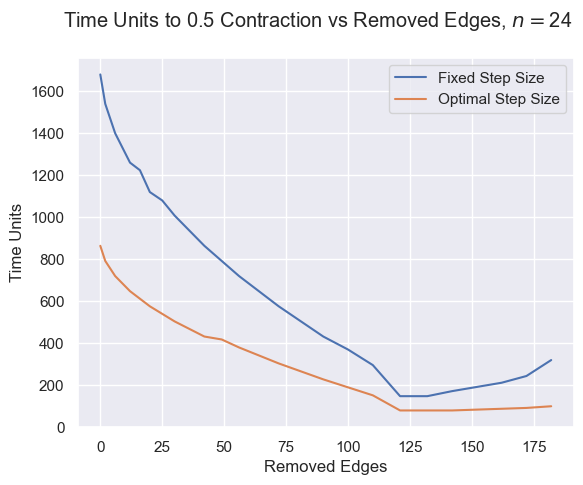

In [36]:

if saving: df.to_csv('figs/n24.csv', index=False)

# Plot total time vs removed edges
plt.plot(df.iloc[3], df.iloc[6], df.iloc[3], df.iloc[7])
# Subtitle
plt.suptitle('Time Units to 0.5 Contraction vs Removed Edges, $n=$'+str(n))


plt.legend( ['Fixed Step Size', 'Optimal Step Size'])
plt.xlabel('Removed Edges')
plt.ylabel('Time Units')
if saving: plt.savefig("figs/fig_optimal_sparsity.pdf", format="pdf", bbox_inches="tight")
plt.show()


0 (47.99999999999555, 0.9610519693852897)
1 (46.00000000002653, 0.9611344874981325)
2 (44.00000000001397, 0.9612008911742602)
3 (41.999999999993534, 0.9612841961148996)
4 (40.00000000033529, 0.9613404323358163)
5 (38.00000000019668, 0.9614511691184635)
6 (36.00000000005643, 0.9615160721244879)
7 (34.00000000000089, 0.9616398317573042)
8 (32.00000000018983, 0.9616501789931347)
9 (29.99999999993441, 0.9618143984054425)
10 (28.000000000015845, 0.9618911233999475)
11 (26.00000000018838, 0.9619696358581257)
12 (23.999999999924594, 0.9620812351429494)
13 (22.000000000001247, 0.9622244218633337)
14 (19.999999999880224, 0.9623042101456656)
15 (17.99999999994352, 0.962424427613141)
16 (15.999999999994683, 0.9624855242813694)
17 (14.000000000000362, 0.9627105025538466)
18 (11.9999999999999, 0.9627679103019492)
19 (10.000000000165414, 0.96304306184268)
20 (7.999999999999933, 0.9630413776592729)
21 (3.9999999999999907, 0.9642038633930519)
22 (3.9999999999999907, 0.9642023236823605)
23 (4.0, 0.9652

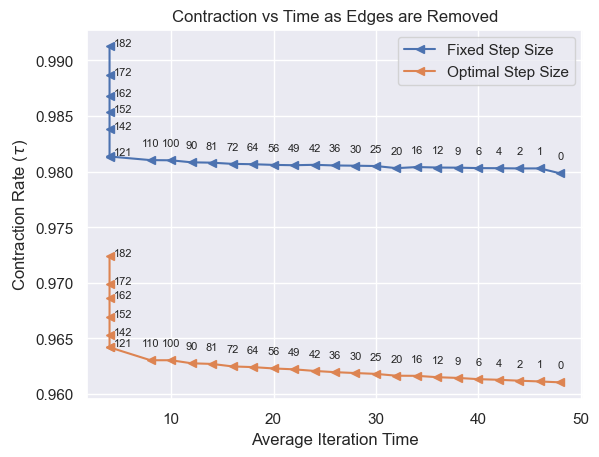

In [37]:
# Figure 10
# Plot the top three rows of df as a function of time with points annotated
plt.plot(df.iloc[2], df.iloc[0], marker='<')
plt.plot(df.iloc[2], df.iloc[1], marker='<')

plt.title('Contraction vs Time as Edges are Removed')
# Add legend
plt.legend( ['Fixed Step Size', 'Optimal Step Size'])
# Annotate points with number of removed edges
lx, ly = (0,0)
right = 0
up = 10
for j in range(len(df.columns)):
        print(j,(df.iloc[2,j], df.iloc[1,j]))
        if df.iloc[2,j] < 4:
                right = 10
                up = 1
        if df.iloc[2,j] == 4.0:
                up = 0
        if abs(lx - df.iloc[2,j]) > 1 or abs(ly - df.iloc[1,j]) > 0.001:
                plt.annotate(df.columns[j], (df.iloc[2,j], df.iloc[0,j]), textcoords="offset points", xytext=(right,up), ha='center', fontsize=8)
                plt.annotate(df.columns[j], (df.iloc[2,j], df.iloc[1,j]), textcoords="offset points", xytext=(right,up), ha='center', fontsize=8)
                lx = df.iloc[2,j]
                ly = df.iloc[1,j]
        
# Annotate with points

plt.xlabel('Average Iteration Time')
plt.ylabel(r'Contraction Rate ($\tau$)')

if saving: plt.savefig("figs/fig_pareto.pdf", format="pdf", bbox_inches="tight")
plt.show()

Figure 11 just shows how we removed the edges

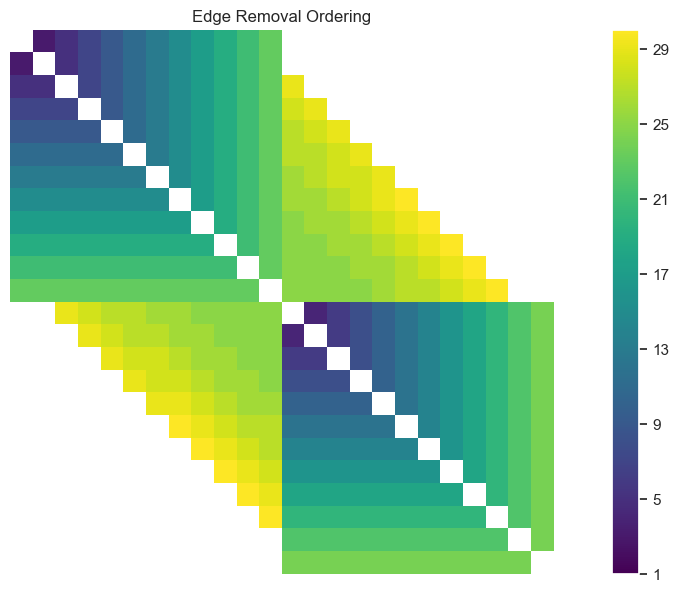

In [38]:
# Figure 11 - edge deletion ordering

def cplot(M, c, title=''):
    vmin = 1
    vmax = np.max(ordermat)
    cm = plt.cm.viridis #coolwarm
    fig, ax = plt.subplots(1, 1, figsize=(12, 6))
    x = np.arange(n)
    y = -np.arange(n)
    pc = ax.pcolormesh(x, y, M, cmap=cm , vmin=vmin, vmax=vmax)
    ax.set_title(title) #'Edge Removal Ordering'
    ax.axis('off')
    ax.set_aspect('equal')

    # Add colorbar
    plt.tight_layout()
    
    cbar = fig.colorbar(pc) 
    cbar.set_ticks(np.arange(1, c, 4)) 
    return fig

# Display edge removal ordering
def order_graph(n):
    order_matrix = np.zeros((n,n)) 
    counter = 1
    for i in range(n//2):
        start = 0
        for k in range(2):
            for j in range(start, i + k*(n//2)):
                r = i + k*(n//2)
                c = j
                order_matrix[(r,j)] = counter
                order_matrix[(c,r)] = counter
            
            counter += 1
            start = n//2

    ccounter = 0
    for i in range(n//2 - 2):
        for j in range(i+1):
            r = n//2 + j
            c = n//2 - 1 - i + j
            order_matrix[(r, c)] = counter
            order_matrix[(c, r)] = counter
            ccounter += 1
            if ccounter % 10 == 0:
                counter += 1
            
    return order_matrix, counter
ordermat, c = order_graph(24)
ordermat = np.ma.masked_array(ordermat, ordermat < 1)

fig = cplot(ordermat, c, 'Edge Removal Ordering')
if saving: fig.savefig("figs/fig_edge_removal.pdf")


Figure 12 then combines the iteration time and contraction factor to find the total time required for a given contraction level, and compares the 2-Block design with the constrained minimum iteration time design, using the minimum total effective resistance objective for each.

It demonstrates some additional parameters in the `getMinIteration` function. `minW=n//2` sets the minimum number of edges for each node in the graph of $W$ to be $\frac{n}{2}$, which we call the constrained minimum iteration time design.

We also introduce the `getMetrics` function, which returns the iteration time, contraction factor, total cycles, and total time for a given contraction target, over a given design ($Z, W$), compute and communication times ($t, l$), and operator parameters (using the default values in Class 1).

In [39]:
# Figure 12
block_results = []
min_results = []
for n in range(6,10):
    for i in range(40):
        t = np.random.rand(n)*10+1

        # Communication time
        l = np.random.rand(n, n)*1.5 + 0.5
        l = np.tril(l, -1) + np.tril(l, -1).T
        Zb, Wb = getBlockMin(n, n//2, builder=getMinResist)
        c, tau, cc, tt = getMetrics(Zb, Wb, t, l,contraction_target=0.01)
        block_results.append((n, i, c, tau, cc, tt))
        Z, W = getMinIteration(n, builder=getMinResist, t=t, l=l, c=0.01, r=n, minW=n//2)
        if Z is not None:
            c, tau, cc, ttc = getMetrics(Z, W, t, l,contraction_target=0.01)
        else:
            c, tau, cc, ttc = (None, None, None, None)
        min_results.append((n, i, c, tau, cc, ttc))
        print(n,i,tt,ttc)
        

6 0 670.4886897131029 670.4886897131029
6 1 778.643903904538 694.5692581525664
6 2 615.006840052717 615.006840052717
6 3 664.7031827966202 664.7031827966202
6 4 698.4652093107794 609.2499864585676
6 5 688.0880207701939 688.0880207701939
6 6 577.4186832479074 513.2587602400457
6 7 675.5954285310031 675.5954285310031
6 8 652.2238505242201 632.6068381216719
6 9 623.2432588359057 498.47284290251457
6 10 530.4714698292019 530.4714698292019
6 11 487.89630928740723 487.89630928740723
6 12 616.5828737639896 616.5828737639896
6 13 545.1163811472464 496.95239405209304
6 14 715.8385535884668 544.7866595980308
6 15 718.7565870708886 718.7565870708886
6 16 508.98055829220084 508.98055829220084
6 17 618.5273437625365 618.5273437625365
6 18 587.1497931809487 587.1497931809487
6 19 697.2152163421836 697.2152163421836
6 20 525.217813021972 525.217813021972
6 21 653.3343949915621 653.3343949915621
6 22 451.8401413427987 395.53697807569
6 23 541.1292509237803 541.1292509237803
6 24 560.1621320320938 560.

In [40]:
# Figure 12
block_df = pd.DataFrame(block_results)
min_df = pd.DataFrame(min_results)

if saving: 
    block_df.to_csv('figs/block_df2.csv')
    min_df.to_csv('figs/min_cycle_min_edge.csv')

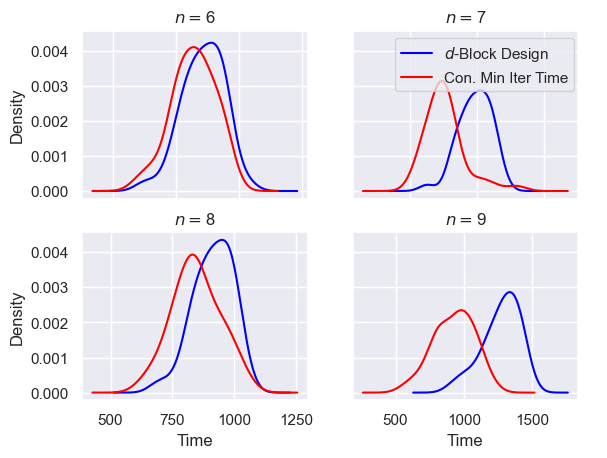

In [41]:
# Figure 12
# Paired density chart for block vs min cycle

fig, axs = plt.subplots(2, 2, sharey=True)
n = 6
key = 5 #'5' #use string if loading from csv
start = 0
for i in range(2):
    for j in range(2):
        end = 40 + start
        axs[i,j] = block_df[key][start:end].plot.kde(ax=axs[i,j], color='blue')
        min_df[key][start:end].plot.kde(ax=axs[i,j], color='red')
        start += 40
        axs[i,j].set_title(r"$n=$"+str(n))
        n += 1

fig.legend([r'$d$-Block Design', 'Con. Min Iter Time'], loc=(.65,.8))

for ax in axs.flat:
    ax.set(xlabel='Time')
for ax in fig.get_axes():
    ax.label_outer()
if saving: fig.savefig("figs/fig_constrained_mincycle_histogram.pdf", format="pdf", bbox_inches="tight")



